# Train With Custom Loop

## Define Custom Functions for Training

In [1]:
import torch
from transformers import T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset

class TranslationDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, prefix):
        self.inputs = [prefix + inp for inp in inputs]
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        source = self.tokenizer(self.inputs[idx], return_tensors="pt", padding='max_length', truncation=True, max_length=128)
        target = self.tokenizer(self.targets[idx], return_tensors="pt", padding='max_length', truncation=True, max_length=128)
        return source.input_ids.squeeze(0), source.attention_mask.squeeze(0), target.input_ids.squeeze(0)

In [2]:
from tqdm import tqdm

def generate_translations(model, tokenizer, source_texts, prefix="Translate Tibetan to English: ", batch_size=8):
    model.eval()
    generated_translations = []
    
    # Process in batches
    for i in tqdm(range(0, len(source_texts), batch_size), desc=f'Generating for {prefix}'):
        batch_texts = source_texts[i:i + batch_size]
        
        # Tokenize batch
        inputs = tokenizer([prefix + text for text in batch_texts],
                           return_tensors="pt", padding='max_length', truncation=True, max_length=128).to(model.device)
        
         # Remove any unnecessary arguments (like 'token_type_ids')
        inputs = {key: value for key, value in inputs.items() if key != 'token_type_ids'}
        
        # Generate outputs
        with torch.no_grad():
            output_ids = model.generate(**inputs)
        
        # Decode batch
        generated_texts = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        generated_translations.extend(generated_texts)
    
    return generated_translations

## Define Metrics

In [3]:
import sacrebleu

def calculate_metrics(preds, references, task):
    """
    Calculate BLEU and ChrF scores for the generated translations.
    :param generated: List of generated translations
    :param references: List of reference translations (gold standard)
    """

    # SacreBLEU expects reference translations to be a list of lists
    bleu = sacrebleu.corpus_bleu(preds, [references])
    chrf = sacrebleu.corpus_chrf(preds, [references])
    ter = sacrebleu.corpus_ter(preds, [references])
    

    metrics = {
        f"{task}_BLEU": round(bleu.score,3),
        f"{task}_ChrF" : round(chrf.score,3),
        f"{task}_TER": round(ter.score,3)
    }

    return metrics

## Load Data and Model for Training

In [4]:
from datasets import load_from_disk
from transformers import AutoTokenizer

ds = load_from_disk('ape-ds')

# Load model and tokenizer
model_name = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained('my-tokenizer')
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# training data
source_sentences = ds['train']['bo']
target_sentences = ds['train']['en']

# eval data
eval_sources = ds['test']['bo']
eval_targets = ds['test']['en']

## Train on Combined Translation and Post Edit Datasets

In [5]:
from tqdm import tqdm
import torch

# Optimizer & Device Setup
optimizer = torch.optim.Adafactor(model.parameters(), lr=3e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Parameters
batch_size = 8  # Increased batch size for efficiency
epochs = 10
metrics = {}

for epoch in range(epochs):
    model.train()
    print(f"Starting Epoch {epoch+1}")
    
    if epoch == 0:
        # Initial training for translation
        translation_dataset = TranslationDataset(source_sentences, target_sentences, tokenizer, "Translate Tibetan to English: ")
        dataloader = DataLoader(translation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    
    total_loss = 0
    
    # Train model for one epoch
    for input_ids, attention_mask, labels in tqdm(dataloader, desc=f'Epoch {epoch+1}', unit="batch"):
        input_ids, attention_mask, labels = input_ids.to(device, non_blocking=True), \
                                           attention_mask.to(device, non_blocking=True), \
                                           labels.to(device, non_blocking=True)
        labels[labels == tokenizer.pad_token_id] = -100  # Ignore padding in loss
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = round(total_loss / len(dataloader), 3)
    
    # Calculate evaluation metrics
    eval_translations = generate_translations(model, tokenizer, eval_sources, batch_size=batch_size)
    
    epoch_metrics = calculate_metrics(eval_translations, eval_targets, 'translation')
    
    epoch_metrics['training_loss'] = avg_loss
    metrics[f'Epoch {epoch+1}'] = epoch_metrics
    print(f'Epoch {epoch+1} Metrics: {epoch_metrics}')


Starting Epoch 1


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:18<00:00,  3.96it/s]


Epoch 1 Metrics: {'translation_BLEU': 4.946, 'translation_ChrF': 22.116, 'translation_TER': 186.988, 'training_loss': 5.257}
Starting Epoch 2


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:20<00:00,  3.95it/s]


Epoch 2 Metrics: {'translation_BLEU': 8.382, 'translation_ChrF': 30.39, 'translation_TER': 166.664, 'training_loss': 3.752}
Starting Epoch 3


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:22<00:00,  3.94it/s]


Epoch 3 Metrics: {'translation_BLEU': 12.018, 'translation_ChrF': 37.452, 'translation_TER': 156.364, 'training_loss': 2.852}
Starting Epoch 4


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:28<00:00,  3.91it/s]


Epoch 4 Metrics: {'translation_BLEU': 15.663, 'translation_ChrF': 43.951, 'translation_TER': 148.817, 'training_loss': 2.198}
Starting Epoch 5


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:31<00:00,  3.89it/s]


Epoch 5 Metrics: {'translation_BLEU': 18.962, 'translation_ChrF': 49.504, 'translation_TER': 138.781, 'training_loss': 1.722}
Starting Epoch 6


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:33<00:00,  3.88it/s]


Epoch 6 Metrics: {'translation_BLEU': 21.658, 'translation_ChrF': 53.856, 'translation_TER': 132.931, 'training_loss': 1.371}
Starting Epoch 7


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:34<00:00,  3.87it/s]


Epoch 7 Metrics: {'translation_BLEU': 24.378, 'translation_ChrF': 57.864, 'translation_TER': 126.001, 'training_loss': 1.112}
Starting Epoch 8


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:43<00:00,  3.82it/s]


Epoch 8 Metrics: {'translation_BLEU': 26.556, 'translation_ChrF': 60.477, 'translation_TER': 124.288, 'training_loss': 0.914}
Starting Epoch 9


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:38<00:00,  3.85it/s]


Epoch 9 Metrics: {'translation_BLEU': 27.961, 'translation_ChrF': 62.652, 'translation_TER': 121.201, 'training_loss': 0.762}
Starting Epoch 10


Generating for Translate Tibetan to English: 100%|██████████| 2689/2689 [11:43<00:00,  3.82it/s]


Epoch 10 Metrics: {'translation_BLEU': 29.687, 'translation_ChrF': 65.038, 'translation_TER': 116.183, 'training_loss': 0.643}


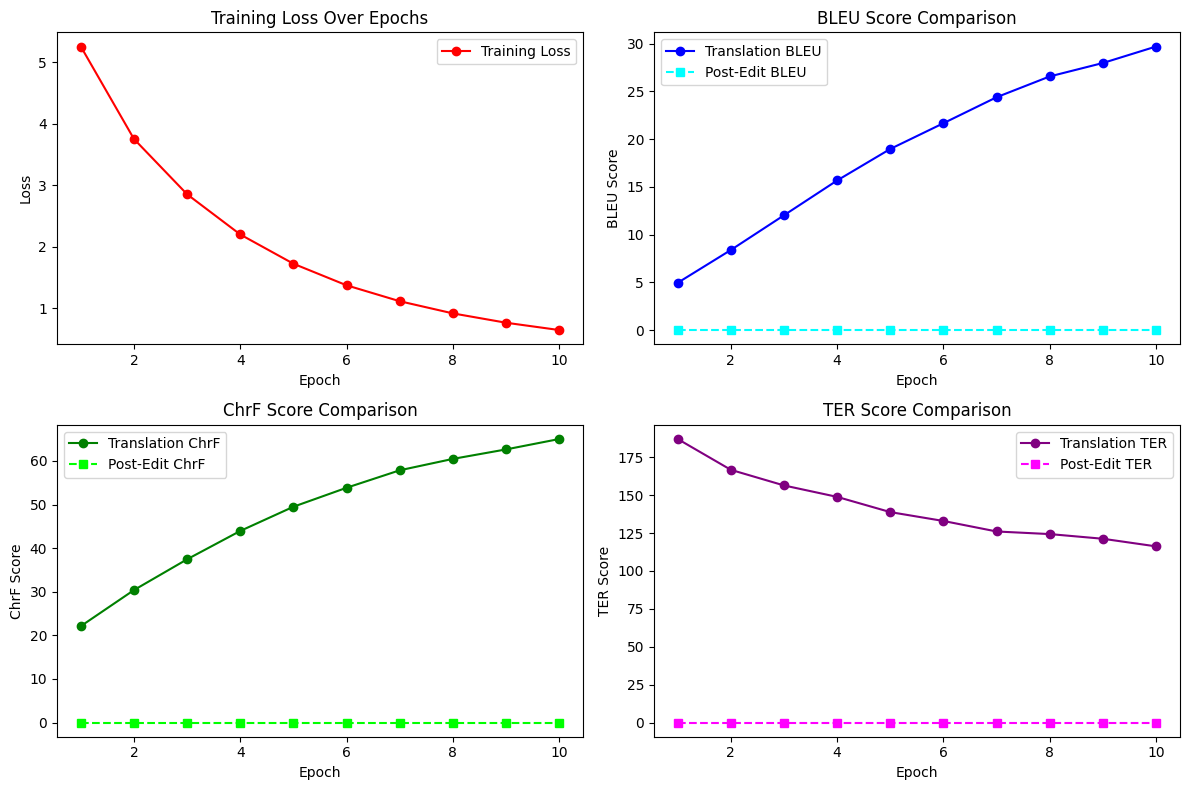

In [7]:
import matplotlib.pyplot as plt

# Extract epochs
epochs = list(metrics.keys())

# Extract metric values
training_loss = [metrics[epoch]["training_loss"] for epoch in epochs]

translation_BLEU = [metrics[epoch]["translation_BLEU"] for epoch in epochs]
post_edit_BLEU = [metrics[epoch].get("post-edit_BLEU", None) for epoch in epochs]

translation_ChrF = [metrics[epoch]["translation_ChrF"] for epoch in epochs]
post_edit_ChrF = [metrics[epoch].get("post-edit_ChrF", None) for epoch in epochs]

translation_TER = [metrics[epoch]["translation_TER"] for epoch in epochs]
post_edit_TER = [metrics[epoch].get("post-edit_TER", None) for epoch in epochs]

# Convert None values to avoid plotting errors
post_edit_BLEU = [x if x is not None else 0 for x in post_edit_BLEU]
post_edit_ChrF = [x if x is not None else 0 for x in post_edit_ChrF]
post_edit_TER = [x if x is not None else 0 for x in post_edit_TER]

# Switch epochs to just be numbers

epochs = range(1,len(epochs)+1)

# Create plots
plt.figure(figsize=(12, 8))

# Plot Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, training_loss, marker='o', linestyle='-', color='r', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Plot BLEU Scores
plt.subplot(2, 2, 2)
plt.plot(epochs, translation_BLEU, marker='o', linestyle='-', label="Translation BLEU", color="blue")
plt.plot(epochs, post_edit_BLEU, marker='s', linestyle='--', label="Post-Edit BLEU", color="cyan")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison")
plt.legend()

# Plot ChrF Scores
plt.subplot(2, 2, 3)
plt.plot(epochs, translation_ChrF, marker='o', linestyle='-', label="Translation ChrF", color="green")
plt.plot(epochs, post_edit_ChrF, marker='s', linestyle='--', label="Post-Edit ChrF", color="lime")
plt.xlabel("Epoch")
plt.ylabel("ChrF Score")
plt.title("ChrF Score Comparison")
plt.legend()

# Plot TER Scores
plt.subplot(2, 2, 4)
plt.plot(epochs, translation_TER, marker='o', linestyle='-', label="Translation TER", color="purple")
plt.plot(epochs, post_edit_TER, marker='s', linestyle='--', label="Post-Edit TER", color="magenta")
plt.xlabel("Epoch")
plt.ylabel("TER Score")
plt.title("TER Score Comparison")
plt.legend()

plt.tight_layout()
plt.show()